Phase 3 is Predictive Modeling
 
1.	Define Nifty_Dir_Open =1/0 based on direction (dependent variable) (already derived in phase 2)
2.	Create data partition into train and test data sets (80/20)
3.	Run Binary Logistic Regression with Nifty Direction as dependent variable and previous day global market returns (and VIX) as independent variables.  
You may add more features such as previous day High/Low ratio for Nifty 50 and/or DJI
4.	Check multicollinearity and resolve if present
5.	Check which variables are significant (revise the model if needed)
6.	Obtain ROC curve and AUC for train data
7.	Obtain threshold to balance sensitivity and specificity
  	Go to step 8 only if you are satisfied with model on train data 
8. Obtain ROC curve and AUC for test data (compare with step 6)
9. Use above threshold to obtain sensitivity and specificity for test data 
         (compare with step 7)
10.	Finalize the model

In [ ]:
# Organize imports
import pandas as pd # for data manipulation
import numpy as np # for numerical operations

import statsmodels.api as sm # for statistical models

from statsmodels.stats.outliers_influence import variance_inflation_factor # for VIF calculation
from sklearn.model_selection import train_test_split # for train-test split
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report # for model evaluation

import matplotlib.pyplot as plt # for plotting
import seaborn as sns # for enhanced plotting


In [ ]:
df = pd.read_csv('markets_with_returns.csv')

# List of market return columns to be used in methods below
independent_vars = [
    'DowJones_Return', 'Nasdaq_Return',
    'HangSeng_Return', 'Nikkei_Return',
    'DAX_Return', 'VIX_Return' ]


In [3]:
# 1 - Define Nifty_Dir_Open =1/0 based on direction (dependent variable) (already derived in phase 2)
df['Nifty_Dir_Open'] = (df['Nifty_Return'] > 0).astype(int)

In [ ]:
# 2 - Create data partition into train and test data sets (80/20)

train_df, test_df = train_test_split(df, test_size=0.2, random_state=123)


In [ ]:
# 3 - Build Logistic Regression Model with Nifty_Dir_Open as dependent variable and market returns as independent variables

# Add a constant to the independent variables (for the intercept term)
X_train = sm.add_constant(train_df[independent_vars])
X_test = sm.add_constant(test_df[independent_vars])
# Define the dependent variable
y_train = train_df['Nifty_Dir_Open']
y_test = test_df['Nifty_Dir_Open']

# Build the logistic regression model
model = sm.Logit(y_train.astype(int), X_train.astype(int)).fit()

# Summarize the model
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.674840
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:         Nifty_Dir_Open   No. Observations:                 1317
Model:                          Logit   Df Residuals:                     1310
Method:                           MLE   Df Model:                            6
Date:                Tue, 11 Nov 2025   Pseudo R-squ.:                 0.02425
Time:                        21:56:46   Log-Likelihood:                -888.76
converged:                       True   LL-Null:                       -910.85
Covariance Type:            nonrobust   LLR p-value:                 6.834e-08
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -0.1227      0.057     -2.153      0.031      -0.234      -0.011
DowJones_Retur

In [ ]:
# 4 - Check multicollinearity and remove variables with high VIF if necessary

# Check VIF for multicollinearity
vif_data = pd.DataFrame()
vif_data["feature"] = X_train.columns
vif_data["VIF"] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
print(vif_data)

# remove from indenpendent_vars any variable with VIF > 5
filtered_vars = []

# Loop through each variable in the original list
for var in independent_vars:
    # Find the VIF value for this variable
    vif_value = vif_data.loc[vif_data['feature'] == var, 'VIF'].values[0]

    # Check if VIF is acceptable (≤ 5)
    if vif_value <= 5:
        filtered_vars.append(var)

# Update the independent_vars list
independent_vars = filtered_vars

print(f"\nFinal variables after VIF filtering: {independent_vars}")



           feature       VIF
0            const  1.017287
1  DowJones_Return  2.675224
2    Nasdaq_Return  2.485189
3  HangSeng_Return  1.054181
4    Nikkei_Return  1.063267
5       DAX_Return  1.227375
6       VIX_Return  2.055600

Final variables after VIF filtering: ['DowJones_Return', 'Nasdaq_Return', 'HangSeng_Return', 'Nikkei_Return', 'DAX_Return', 'VIX_Return']


In [ ]:
# 5 - Rebuild Logistic Regression Model with significant independent variables

significant_vars = [
    'HangSeng_Return', 'Nikkei_Return',
    'DAX_Return', 'VIX_Return' ]

X_train_sig = sm.add_constant(train_df[significant_vars])
X_test_sig = sm.add_constant(test_df[significant_vars])

model_sig = sm.Logit(y_train.astype(int), X_train_sig.astype(int)).fit()
print(model_sig.summary())

Optimization terminated successfully.
         Current function value: 0.675524
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:         Nifty_Dir_Open   No. Observations:                 1317
Model:                          Logit   Df Residuals:                     1312
Method:                           MLE   Df Model:                            4
Date:                Tue, 11 Nov 2025   Pseudo R-squ.:                 0.02326
Time:                        21:58:47   Log-Likelihood:                -889.66
converged:                       True   LL-Null:                       -910.85
Covariance Type:            nonrobust   LLR p-value:                 1.397e-08
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -0.1155      0.057     -2.041      0.041      -0.226      -0.005
HangSeng_Retur

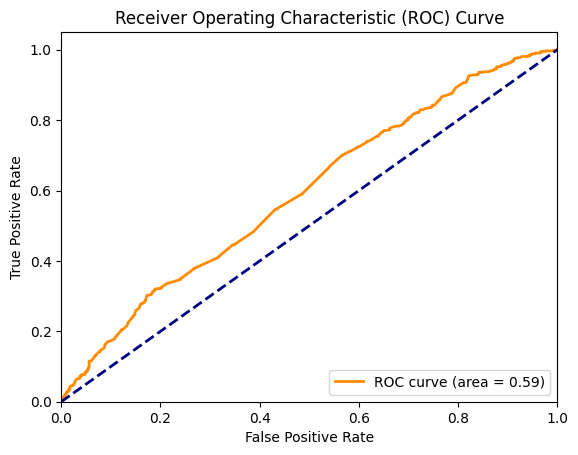

AUC: 0.59


In [ ]:
# 6 - Obtain ROC curve and AUC for train data

# Predict probabilities on the train set and calculate ROC AUC
train_df['predprob'] = model_sig.predict(X_train_sig.astype(int))
fpr, tpr, thresholds = roc_curve(y_train, train_df['predprob'])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# # Print AUC
print(f"AUC: {roc_auc:.2f}")



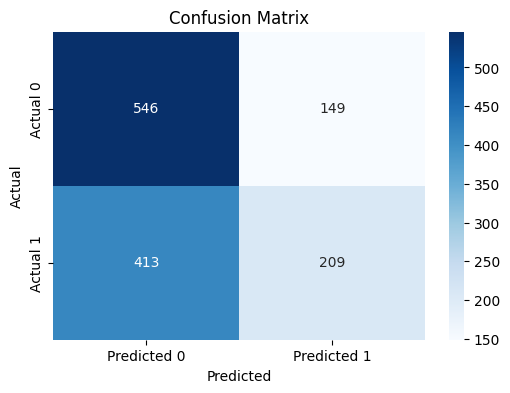

classification report:
               precision    recall  f1-score   support

           0       0.57      0.79      0.66       695
           1       0.58      0.34      0.43       622

    accuracy                           0.57      1317
   macro avg       0.58      0.56      0.54      1317
weighted avg       0.58      0.57      0.55      1317



In [ ]:
# 7 - Get specificity, sensitivity and proceed if we are happy with how are these leveled

# Confusion Matrix and Classification Report
y_pred = model_sig.predict(X_train_sig.astype(int)) >= 0.5
cm = confusion_matrix(y_train, y_pred)
cr = classification_report(y_train, y_pred)

# Plot confusion matrix heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])

plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

print("classification report:\n", cr)

In [ ]:
# Overall accuracy is very low, looking for a better threshold based on ROC curve
# Method 1: Youden's Index (maximizes TPR - FPR)

youden_index = tpr - fpr
optimal_idx = np.argmax(youden_index)
optimal_threshold_youden = thresholds[optimal_idx]
print(f"Optimal threshold by Youden's Index: {optimal_threshold_youden:.4f}")

# Youden index is 0.4632, but testing manually 0.4753 seems to be the one that levels specificity and sensitivity better.

Optimal threshold by Youden's Index: 0.4632


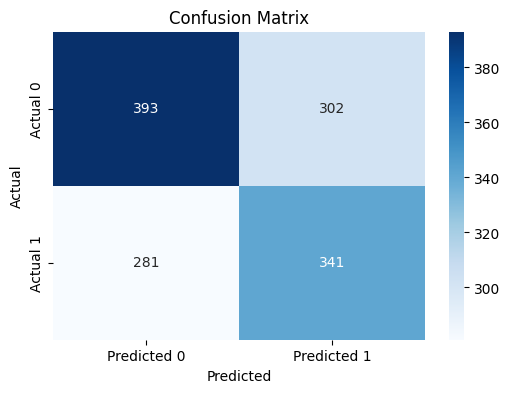

classification report:
               precision    recall  f1-score   support

           0       0.58      0.57      0.57       695
           1       0.53      0.55      0.54       622

    accuracy                           0.56      1317
   macro avg       0.56      0.56      0.56      1317
weighted avg       0.56      0.56      0.56      1317



In [ ]:
# getting new classification report with new threshold on train data

# Confusion Matrix and Classification Report
y_pred = model_sig.predict(X_train_sig.astype(int)) >= 0.4753
cm = confusion_matrix(y_train, y_pred)
cr = classification_report(y_train, y_pred)

# Plot confusion matrix heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])

plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

print("classification report:\n", cr)

# precsision dropped a bit but sensitivity and specificity are now better leveled.

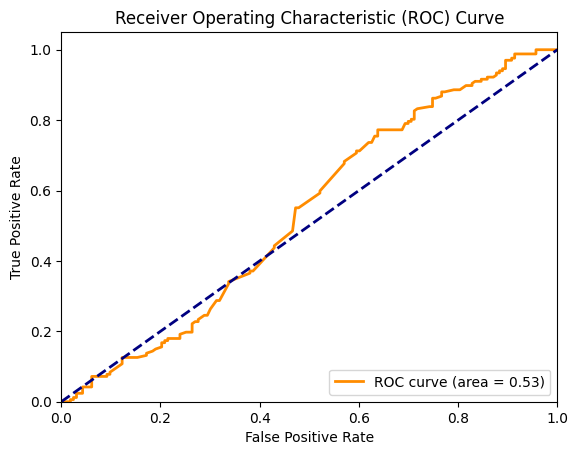

AUC: 0.53


In [ ]:
# 8 - Obtain ROC curve and AUC for test data (compare with step 6)

test_df['predprob'] = model_sig.predict(X_test_sig.astype(int))
fpr_test, tpr_test, thresholds = roc_curve(y_test, test_df['predprob'])
roc_auc_test = auc(fpr_test, tpr_test)

# Plot ROC curve
plt.figure()
plt.plot(fpr_test, tpr_test, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_test:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# # Print AUC
print(f"AUC: {roc_auc_test:.2f}")

# The performance on the test set is consistent with the train set, very low AUC around 0.53 and 0.59 in test and train respectively.

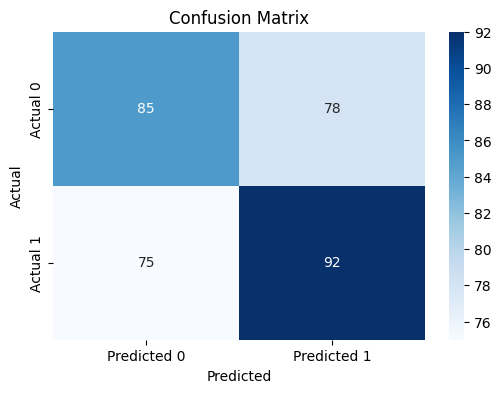

classification report:
               precision    recall  f1-score   support

           0       0.53      0.52      0.53       163
           1       0.54      0.55      0.55       167

    accuracy                           0.54       330
   macro avg       0.54      0.54      0.54       330
weighted avg       0.54      0.54      0.54       330



In [ ]:
# 9 - Confusion Matrix and Classification Report for test data
y_pred_test = model.predict(X_test.astype(int)) >= 0.4753
cm = confusion_matrix(y_test, y_pred_test)
cr = classification_report(y_test, y_pred_test)

# Plot confusion matrix heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])

plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

print("classification report:\n", cr)

# Overall accuracy is very low, at 54% is even lower than the train set at 56%.

In [ ]:
# Conclusion: The logistic regression model built using market returns as independent
# variables to predict the direction of Nifty returns has low predictive power, as
# indicated by the AUC values and classification reports on both train and test datasets.
# The model's ability to distinguish between positive and negative returns is only slightly better than random guessing.